In [1]:
from fastai.vision import *
from datasets import *
from metrics import *

In [73]:
PATH, CODES, TRAIN, VALID, TEST = Path('/root/.fastai/data/camvid'), "codes.txt", "train.txt", "valid.txt", "test.txt"
segdata = SemanticSegmentationData(PATH, CODES, TRAIN, VALID, TEST, None, bs=16, size=224)

In [74]:
data = segdata.get_data().normalize(imagenet_stats)
testdata = segdata.get_testdata().normalize(imagenet_stats)

In [75]:
learn = unet_learner(data, arch = models.resnet34, pretrained = True)

In [76]:
learn.load("mybestmodel");

In [77]:
void_name = "Void"
void_code = np.where(learn.data.classes == void_name)[0].item()
void_code

30

In [78]:
learn.metrics = [partial(foreground_acc, void_code=void_code), partial(multilabel_iou, c=learn.data.c), partial(multilabel_dice, c=learn.data.c)] 

In [79]:
learn.validate(data.valid_dl)

[1.7393475, tensor(0.8913), tensor(0.2759), tensor(0.4537)]

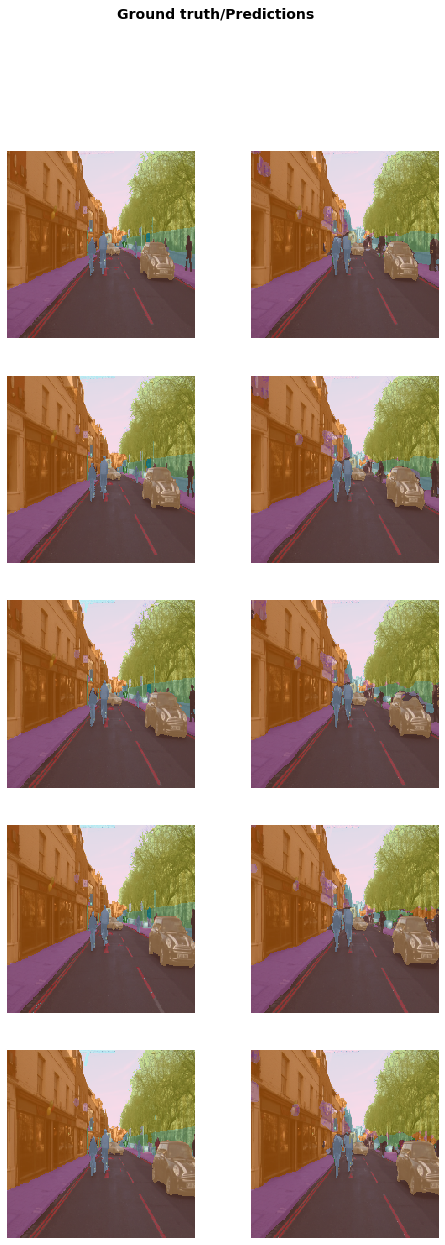

In [80]:
learn.show_results()

In [84]:
def multilabel_dice(input:Tensor, targs:Tensor, c, iou:bool=False, mean=True)->Rank0Tensor:
    "Dataset Mean Dice"
    input = input.argmax(dim=1, keepdim=True).view(-1)
    targs = targs.view(-1)
    res = []
    for ci in range(c):
        _input, _targs = input == ci, targs == ci
        intersect = (_input * _targs).sum().float()
        union = (_input+_targs).sum().float()
        if not iou: res.append((2. * intersect / union if union > 0 else union.new([1.]).squeeze()))
        else: res.append(intersect / (union-intersect+1.0))
    res = torch.tensor(res).to(input.device)
    if not mean: return res
    else: return res.mean()

In [81]:
preds, targs = learn.get_preds()

In [82]:
preds, targs = preds, targs.squeeze(1)

In [85]:
res = multilabel_dice(preds, targs, learn.data.c, iou=True, mean=False)

In [86]:
dict(zip(learn.data.classes, res))

{'Animal': tensor(0.),
 'Archway': tensor(0.),
 'Bicyclist': tensor(0.5291),
 'Bridge': tensor(0.),
 'Building': tensor(0.8229),
 'Car': tensor(0.8475),
 'CartLuggagePram': tensor(0.0165),
 'Child': tensor(0.0034),
 'Column_Pole': tensor(0.0065),
 'Fence': tensor(0.5853),
 'LaneMkgsDriv': tensor(0.6036),
 'LaneMkgsNonDriv': tensor(0.),
 'Misc_Text': tensor(0.0684),
 'MotorcycleScooter': tensor(0.),
 'OtherMoving': tensor(0.3426),
 'ParkingBlock': tensor(0.),
 'Pedestrian': tensor(0.1217),
 'Road': tensor(0.9367),
 'RoadShoulder': tensor(0.),
 'Sidewalk': tensor(0.8900),
 'SignSymbol': tensor(0.0550),
 'Sky': tensor(0.9446),
 'SUVPickupTruck': tensor(0.),
 'TrafficCone': tensor(0.),
 'TrafficLight': tensor(0.5061),
 'Train': tensor(0.),
 'Tree': tensor(0.9080),
 'Truck_Bus': tensor(0.3915),
 'Tunnel': tensor(0.),
 'VegetationMisc': tensor(0.0251),
 'Void': tensor(0.0546),
 'Wall': tensor(0.6324)}

### test iou/dice

In [30]:
dice(torch.tensor([0.]*9).reshape(1,1,3,3), torch.zeros((1,3,3)).long())

tensor(1.)